# Setup

In [1]:
backend_name = 'ibmq_quito'

In [2]:
import icepp
import math
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

from pytket.extensions.qiskit import IBMQBackend, AerStateBackend, AerBackend

from qiskit import *
from qiskit.visualization import plot_histogram
IBMQ.load_account()

# Fill your provider information
# Example: provider = IBMQ.get_provider(hub=ibm-q'',group='open',project='main')
provider = IBMQ.get_provider(hub='',group='',project='')

backend = provider.get_backend(backend_name)
sim_b = AerBackend()
dev_b = IBMQBackend(backend_name=backend_name, hub='',group='',project='')

# Benchmarks

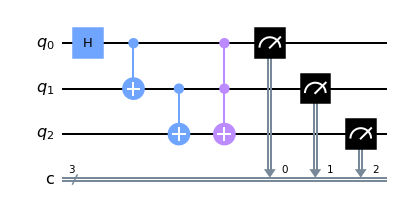

In [3]:
test = QuantumCircuit(3,3)
test.h(0)
test.cx(0,1)
test.cx(1,2)
test.ccx(0,1,2)
test.measure(0,0)
test.measure(1,1)
test.measure(2,2)

test.draw("mpl")

# Only Qiskit + Measurement error mitigation

In [4]:
transpiled_qcs = transpile(test,backend,optimization_level=3)

In [6]:
qc = transpiled_qcs
print(qc.depth(), ',', qc.__len__())
print('Gate counts:', qc.count_ops())

28 , 41
Gate counts: OrderedDict([('cx', 16), ('rz', 15), ('sx', 6), ('measure', 3), ('barrier', 1)])


In [7]:
simulation_counts = icepp.simulator(qc).aer_simulator(shots=1024)
print(simulation_counts)

{'000': 533, '011': 491}


In [7]:
all_mitigated_counts = icepp.pass_manager(qc, level=1, backend=backend, backend_tket=dev_b, shots=1024).auto_manager()

Job id : 26039791684a4096a3e48c1351dfa5f0-16489925437400389
Job Status: job has successfully run
Raw counts: {'000': 464, '001': 37, '010': 38, '011': 401, '100': 27, '101': 10, '110': 26, '111': 21}
Measurement error mitigated counts {'000': 471.72592455643814, '001': 6.2036136696156285, '010': 24.700060269777527, '011': 440.032979218709, '100': 25.46042169956512, '101': 8.90372486505393, '110': 28.244140188478312, '111': 18.729135532362267}


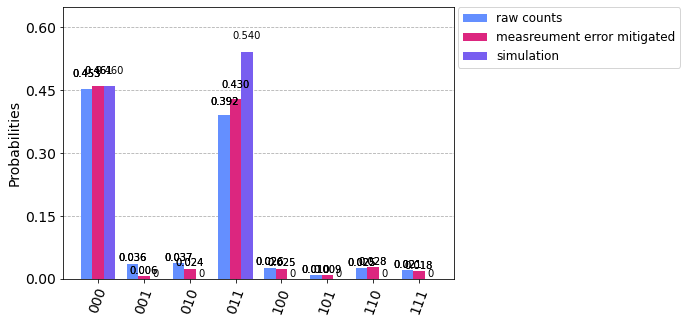

In [8]:
raw_counts, meas_mit_counts= all_mitigated_counts[0], all_mitigated_counts[1]

legend = ['raw counts','measreument error mitigated','simulation']
plot_histogram([raw_counts, meas_mit_counts, simulation_counts], legend=legend)

# AQCEL circuit optimization

In [5]:
aqcel_results_cc = icepp.pass_manager(test, level=2, backend=backend, backend_tket=dev_b, shots=1024, measure_type='cc').auto_manager()

In [5]:
simulation_counts = icepp.simulator(aqcel_results_cc[0]).aer_simulator(shots=1024)
print(simulation_counts)

{'011': 495, '000': 529}


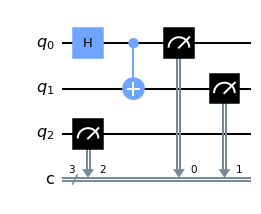

In [6]:
aqcel_results_cc[0].draw('mpl',fold=100)

In [12]:
aqcel_counts_cc = icepp.pass_manager(aqcel_results_cc[1], level=1, backend=backend, backend_tket=dev_b, shots=1024).auto_manager()

Job id : 6d278b1825394bae8b1c74c1c1ff039c-1648992570321526
Job Status: job has successfully run
Raw counts: {'000': 508, '001': 23, '010': 17, '011': 457, '100': 8, '110': 1, '111': 10}
Measurement error mitigated counts {'000': 517.8309068329967, '011': 502.53425137410665, '100': 1.962249807085925e-13, '110': 1.1246559239452836e-13, '111': 3.634841792897358}


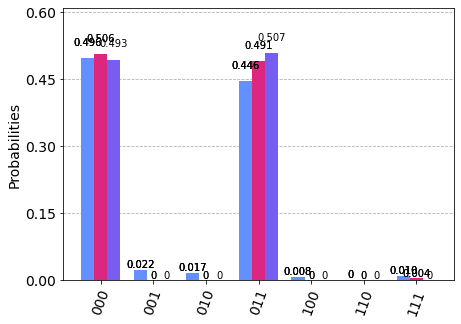

In [13]:
plot_histogram([aqcel_counts_cc[0], aqcel_counts_cc[1],simulation_counts])

In [14]:
aqcel_results_qc = icepp.pass_manager(test, level=2, backend=backend, backend_tket=dev_b, shots=1024, measure_type='qc', threshold_type=['constant',0.1], zne='off').auto_manager()

     ┌───┐ ░ ┌─┐
q_0: ┤ H ├─░─┤M├
     └───┘ ░ └╥┘
q_1: ──────░──╫─
           ░  ║ 
q_2: ──────░──╫─
           ░  ║ 
c: 1/═════════╩═
              0 
Job id : 2801d9de33754488bf7ebb8c49aa5c25-1648992589229192
Job Status: job has successfully run
Raw counts: {'0': 511, '1': 513}
Measurement error mitigated counts {'0': 491.90082597320855, '1': 532.0991740267914}
Final counts after applying the threshold : {'0': 491.90082597320855, '1': 532.0991740267914}
Threshold : 102.4
     ┌───┐      ░    
q_0: ┤ H ├──■───░────
     └───┘┌─┴─┐ ░ ┌─┐
q_1: ─────┤ X ├─░─┤M├
          └───┘ ░ └╥┘
q_2: ───────────░──╫─
                ░  ║ 
c: 1/══════════════╩═
                   0 
Job id : 39afa4e297e148a78f36c4cef4a7bece-1648992611747947
Job Status: job has successfully run
Raw counts: {'0': 513, '1': 511}
Measurement error mitigated counts {'0': 491.04721905158533, '1': 532.9527809484146}
Final counts after applying the threshold : {'0': 491.04721905158533, '1': 532.9527809484146}
Threshold : 102

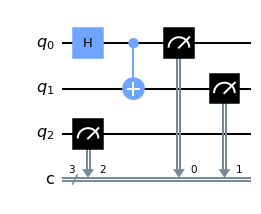

In [15]:
aqcel_results_qc[0].draw('mpl' ,fold=100)

In [16]:
aqcel_counts_qc = icepp.pass_manager(aqcel_results_qc[1], level=1, backend=backend, backend_tket=dev_b, shots=1024).auto_manager()

Job id : 0fd9ca60d8204d3c856f5ee3d6596c81-1648992652522648
Job Status: job has successfully run
Raw counts: {'000': 486, '001': 29, '010': 26, '011': 472, '100': 5, '111': 6}
Measurement error mitigated counts {'000': 498.22313238901427, '011': 525.7768676109858, '100': 3.552713678800501e-15, '110': 1.7763568394002505e-15}


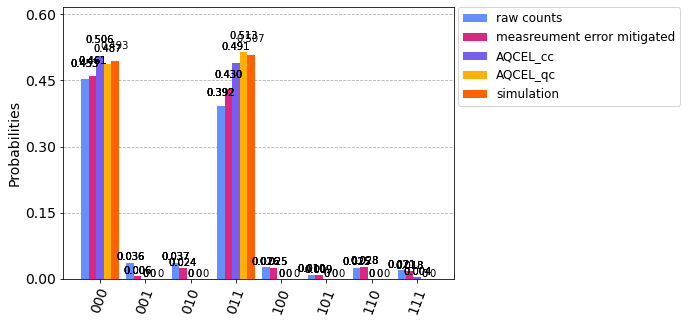

In [18]:
legend = ['raw counts','measreument error mitigated','AQCEL_cc','AQCEL_qc','simulation']
plot_histogram([raw_counts, meas_mit_counts, aqcel_counts_cc[-1], aqcel_counts_qc[-1], simulation_counts], legend=legend)

In [19]:
import math

def fidelity(count1,count2,shots):
    fidelity=0
    for key in count1.keys():
        if (key in count2) and (count1[key] >0) and (count2[key] >0):
            fidelity += math.sqrt((count1[key]*count2[key]))/shots
    return fidelity

def all_fidelities(sim_counts, counts_list, shots):
    fidelity_list = []
    for counts in counts_list:
        each_fidelity = fidelity(sim_counts, counts ,shots)
        fidelity_list.append(each_fidelity)
    return fidelity_list

In [21]:
all_fidelities(sim_counts=simulation_counts, counts_list=all_mitigated_counts+[aqcel_counts_cc[-1],aqcel_counts_qc[-1]], shots=1024)

[0.9182292235867031, 0.9433278097878576, 0.9981210766370407, 0.999978091548282]